<a href="https://colab.research.google.com/github/sofiabouzo/PSB_final/blob/main/Final_PSB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1- definir señales \

2- ver si es necesario filtrar

3- calcular energías con wavelet

4- meter esas energías a ML

#Librerias

In [1]:
#!pip install mne
#import mne

In [2]:
!pip install PyWavelets --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 19.4 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
import scipy.signal as sig
import matplotlib.pyplot as plt
import scipy.io as io
from scipy.fft import fft
from sklearn.linear_model import LinearRegression
import pywt
import scipy

In [5]:
import scipy

In [6]:
fs = 128

#Carga de archivos


In [7]:
def cargaarchivos(matdatos, matlabels):
  for i in range(32):
    base='/content/drive/MyDrive/PSB - FINAL/data_preprocessed_matlab.zip (Unzipped Files)/s#.mat'
    ruta= base.replace('#',str(i+1).zfill(2))
    archivo = io.loadmat(ruta)
    data = archivo['data']
    labels=archivo['labels']
    matdatos[i]=data
    matlabels[i]=labels

matdatos=np.zeros((32,40,40,8064))  #sujeto x trial x canal x dato
matlabels=np.zeros((32,40,4))
cargaarchivos(matdatos, matlabels)
canales=['Fp1', 'AF3', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO3', 'O1', 'Oz', 'Pz', 'Fp2', 'AF4', 'Fz', 'F4', 'F8', 'FC6', 'FC2', 'Cz', 'C4', 'T8', 'CP6', 'CP2', 'P4', 'P8', 'PO4', 'O2', 'hEOG', 'vEOG', 'zEMG', 'tEMG', 'GSR', 'Respiration belt', 'Plethysmograph', 'Temperature']

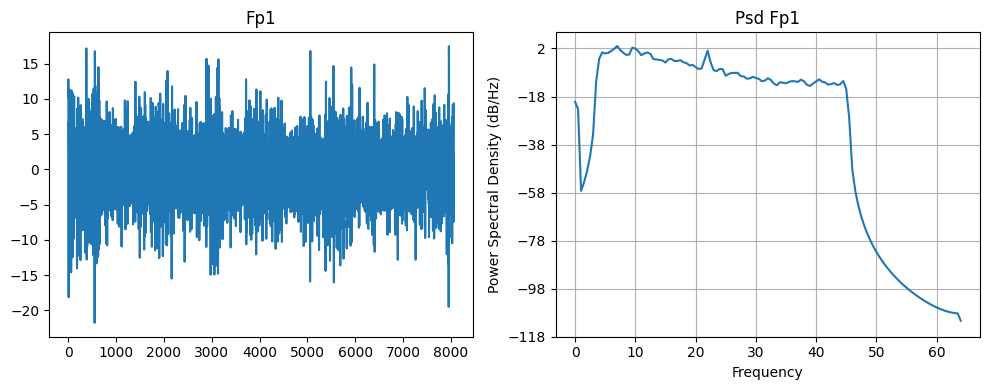

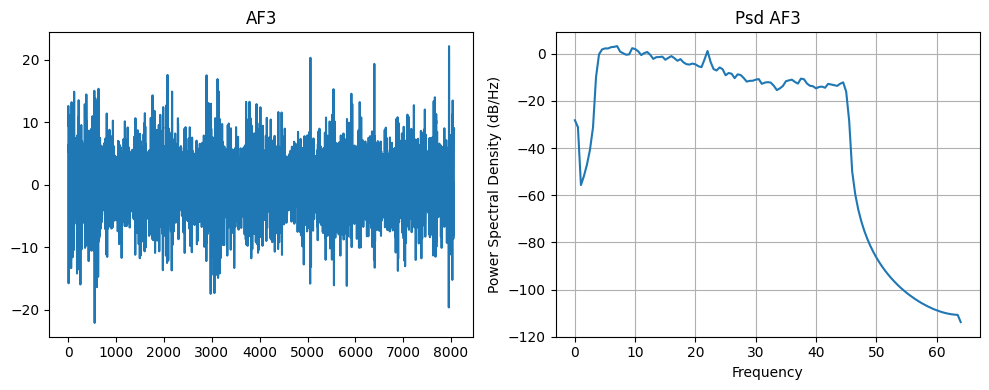

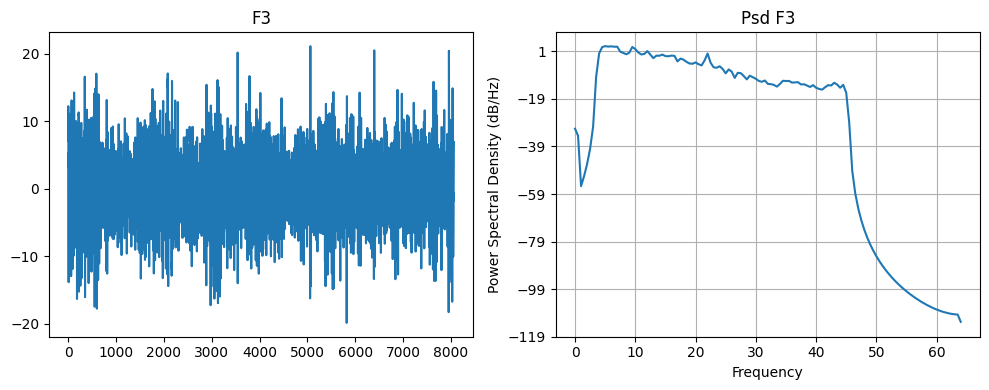

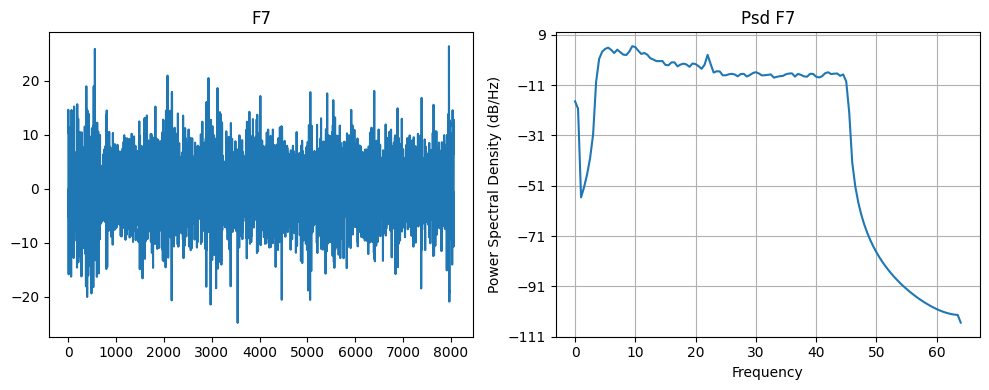

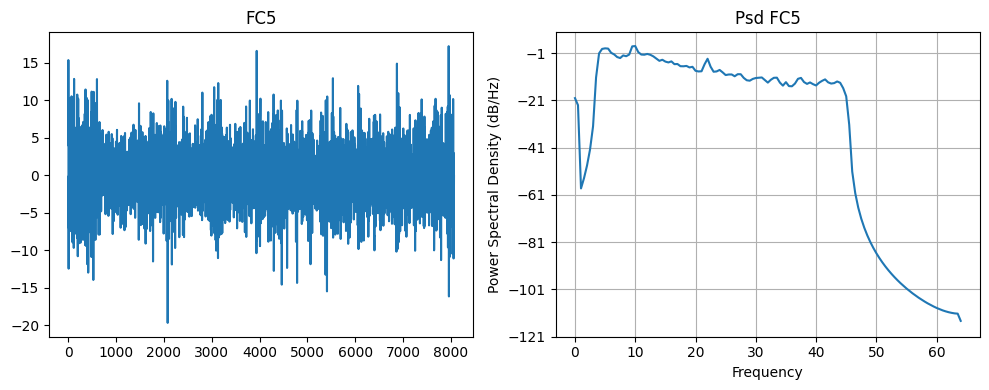

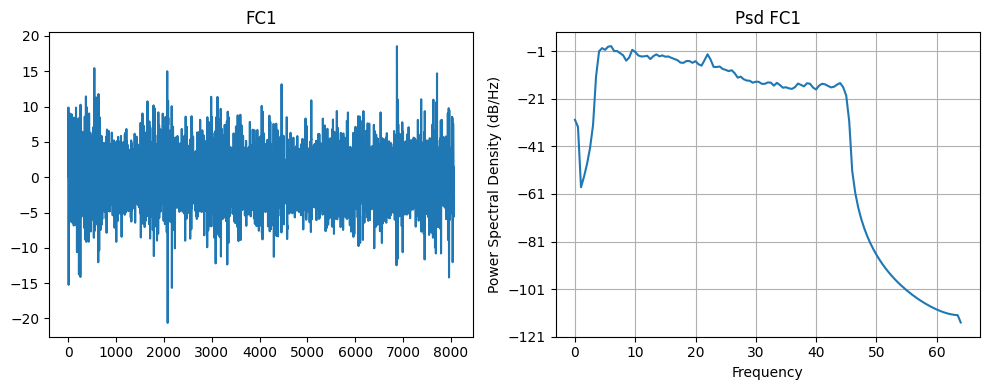

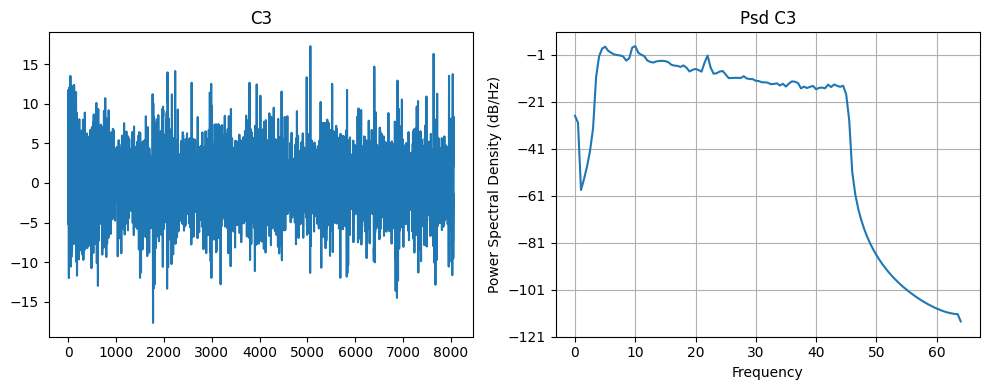

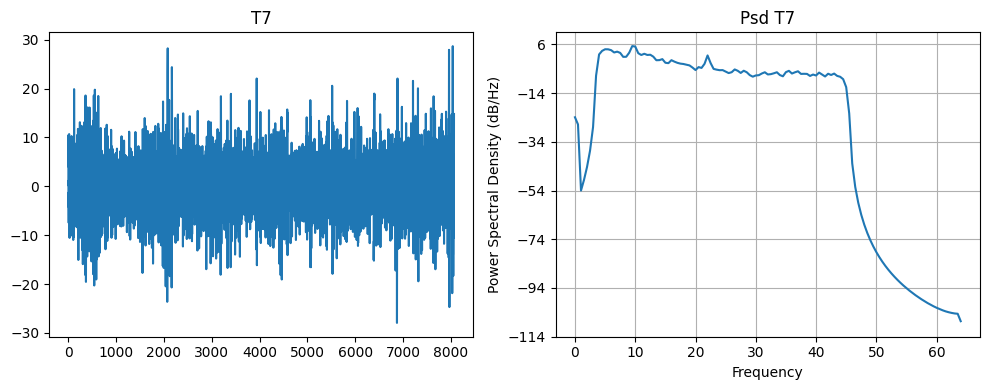

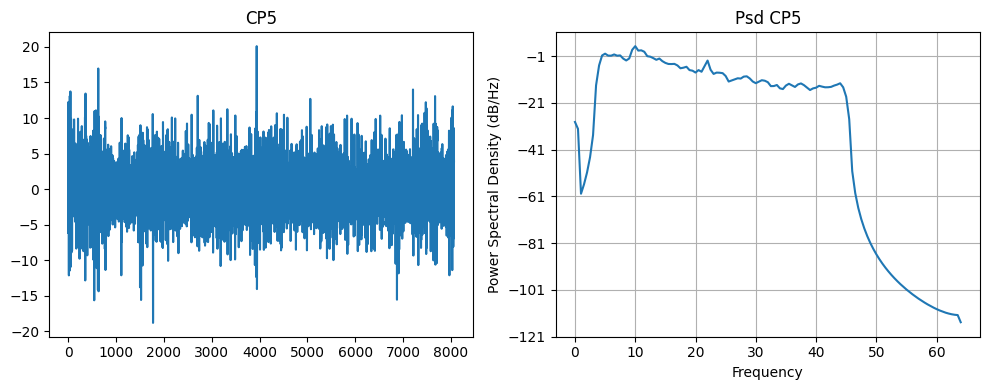

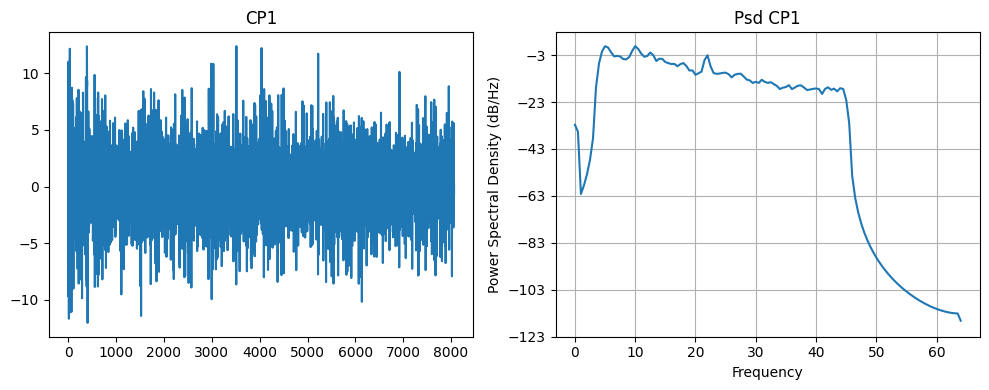

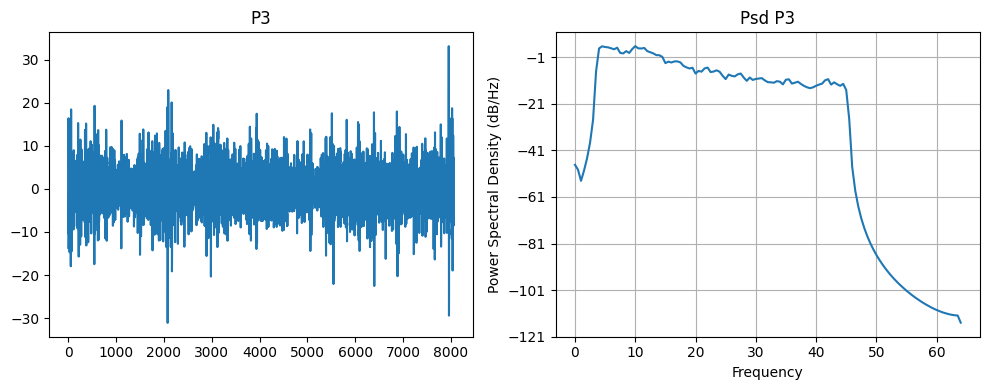

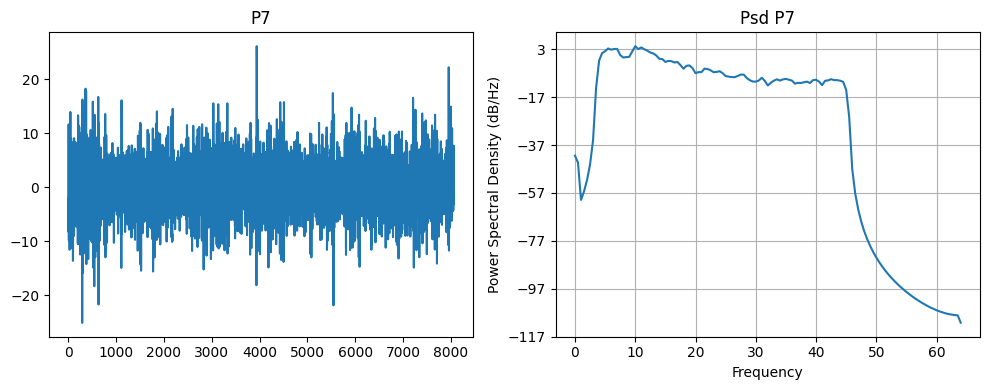

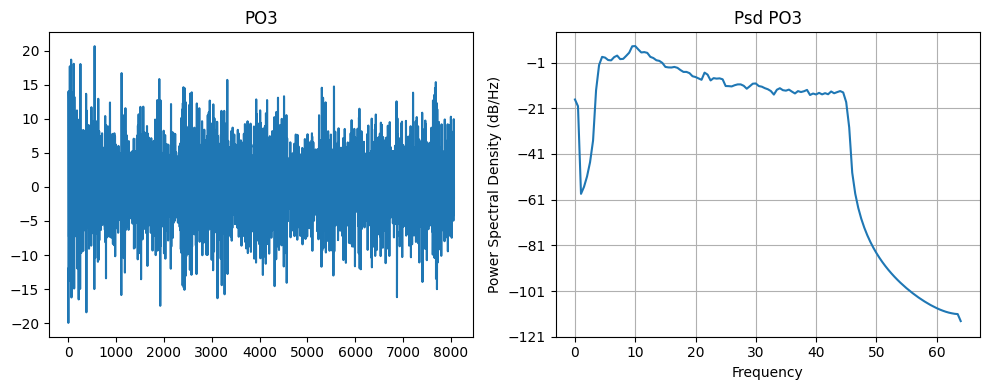

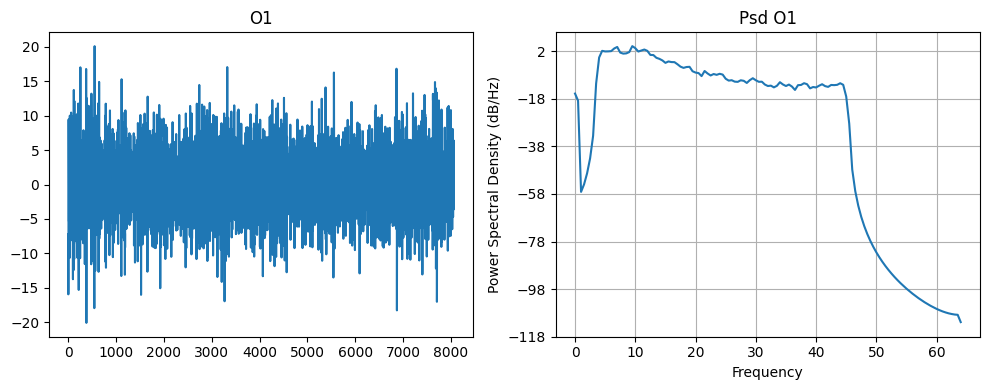

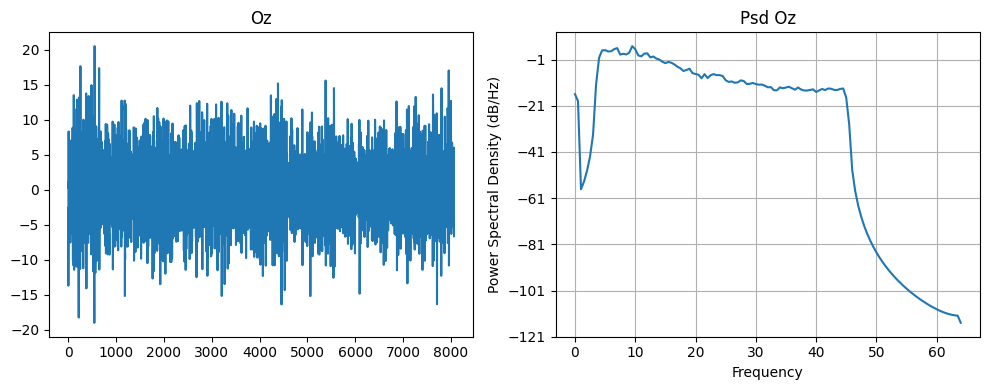

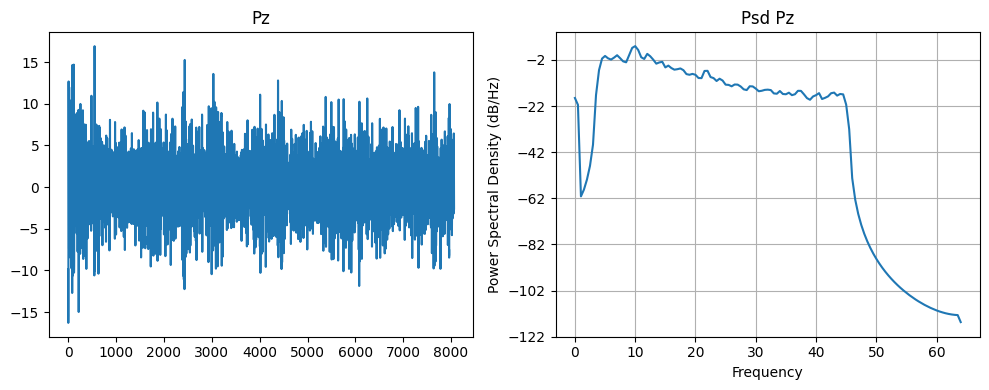

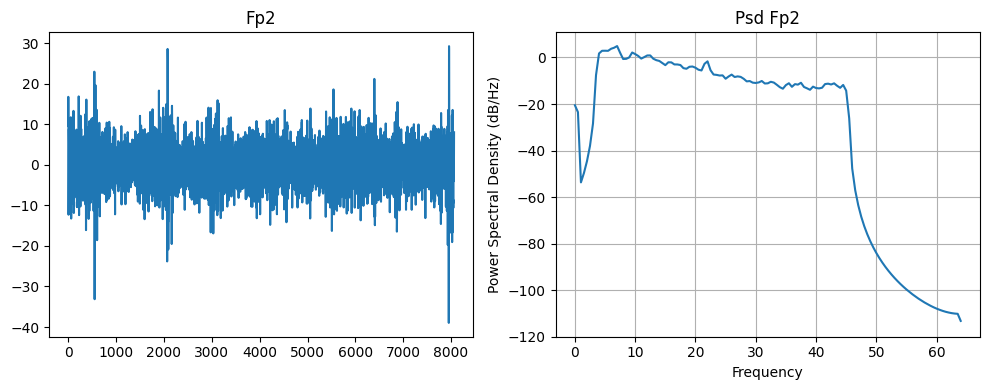

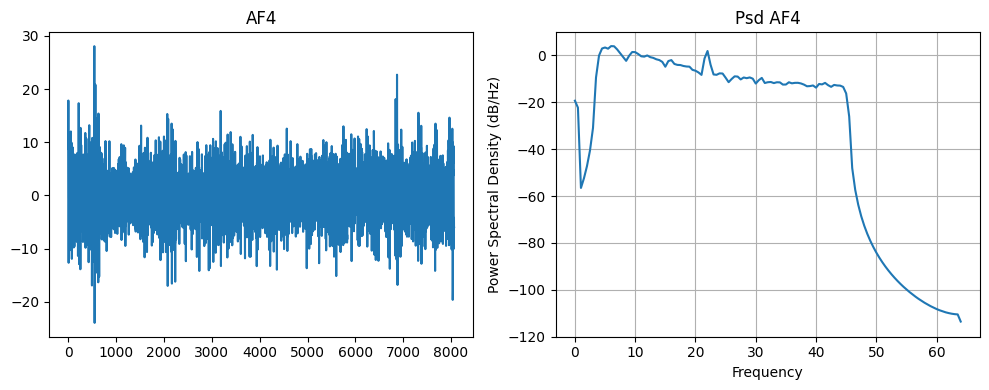

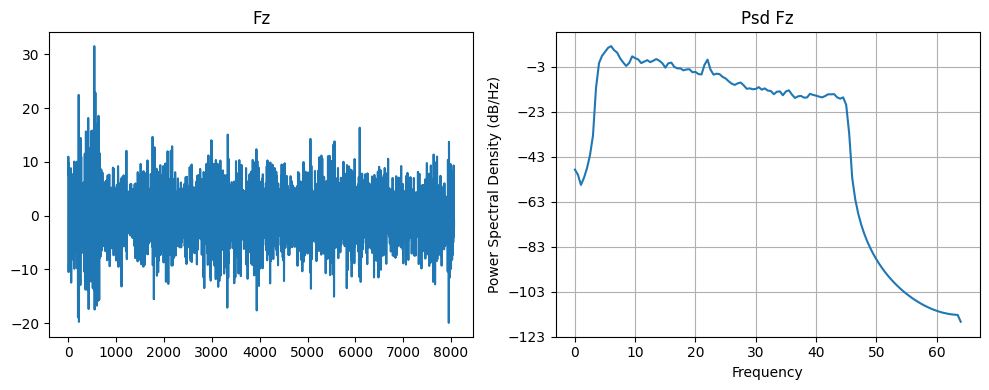

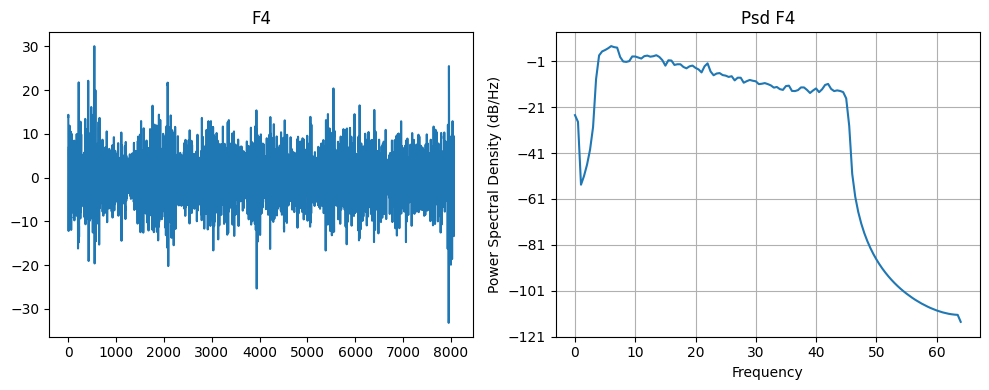

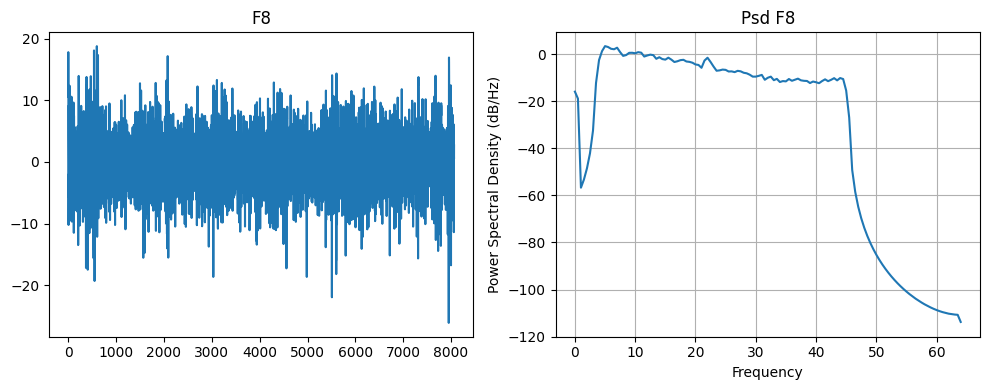

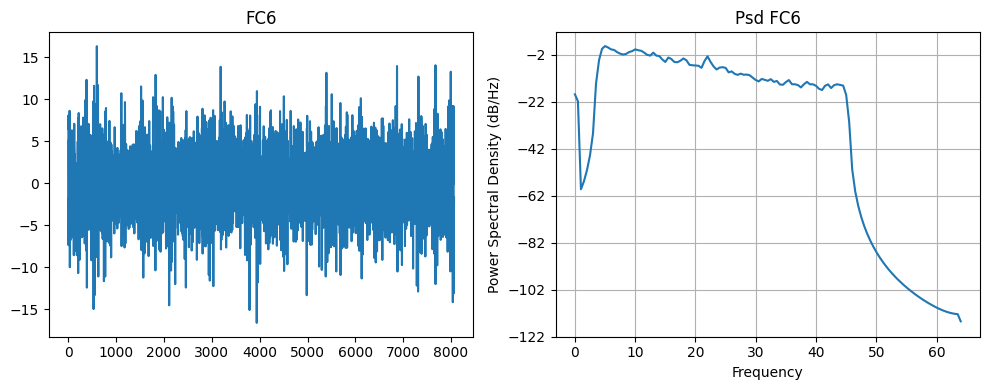

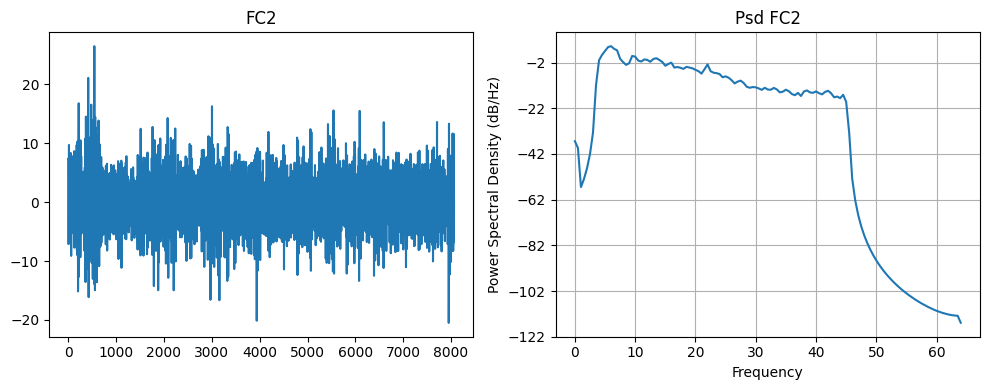

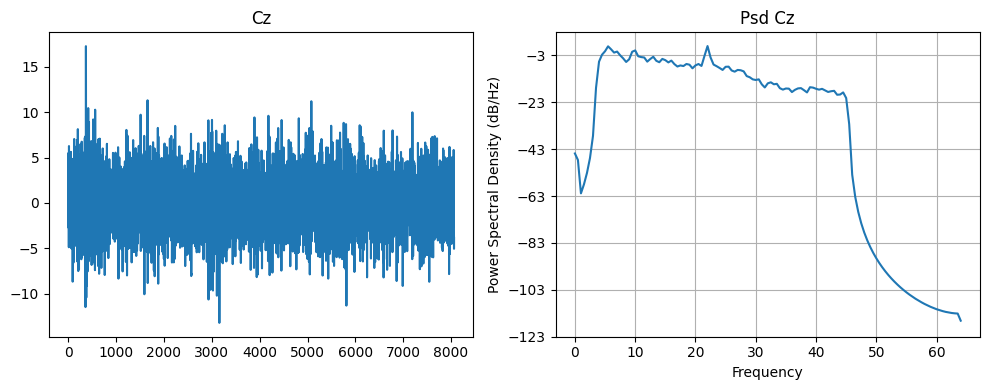

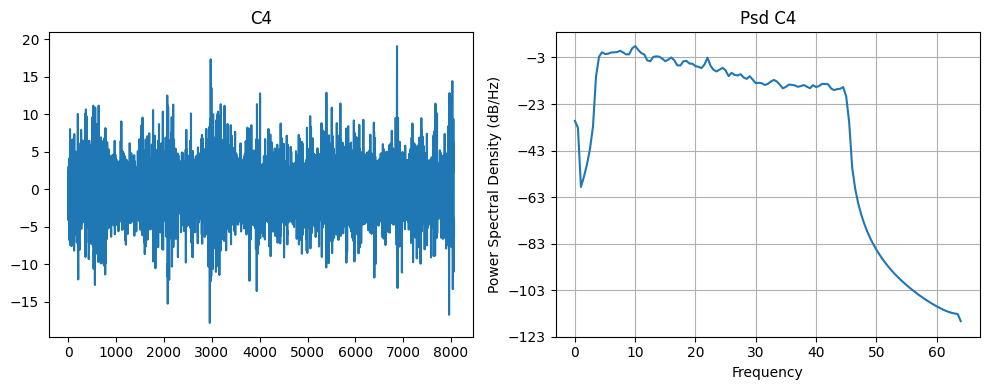

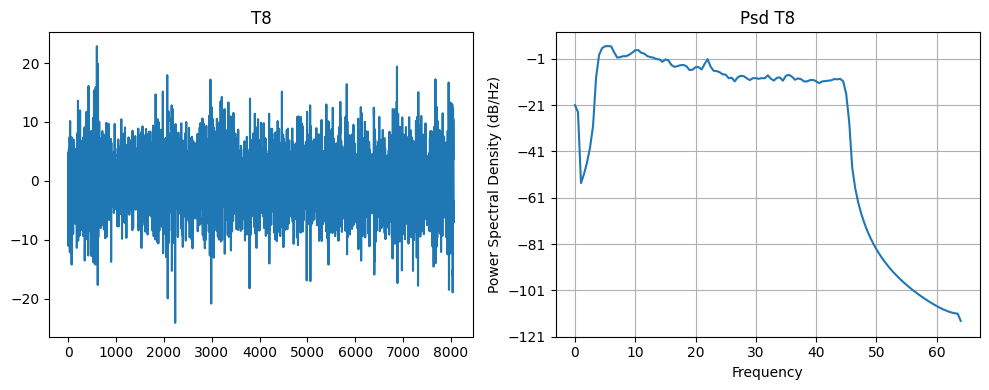

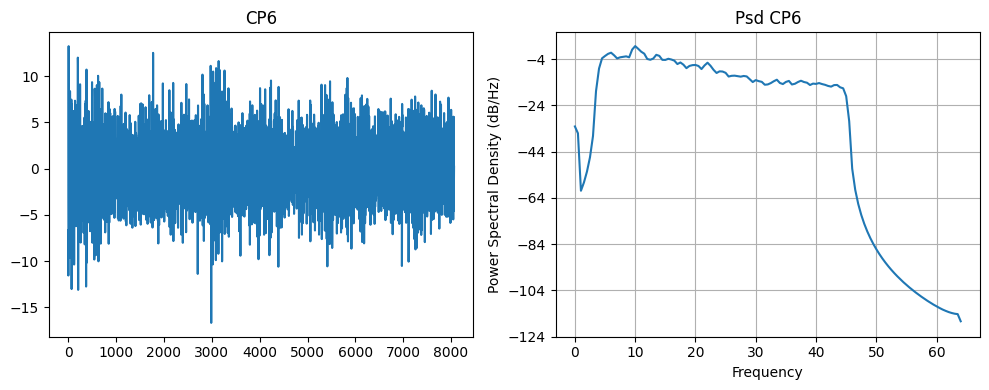

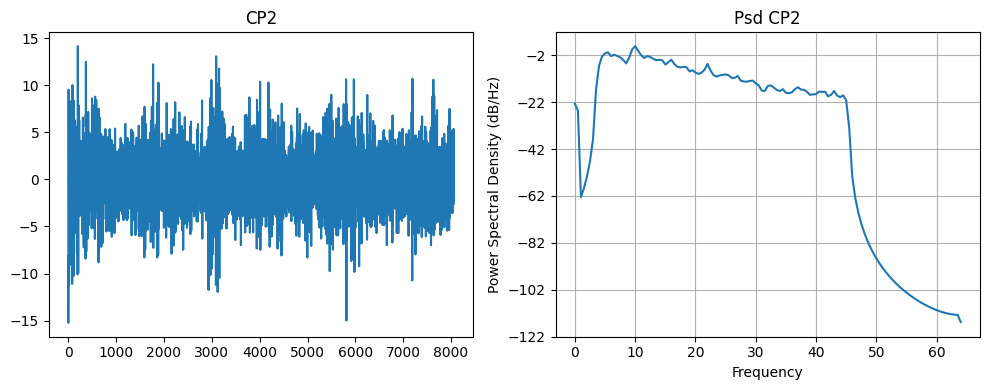

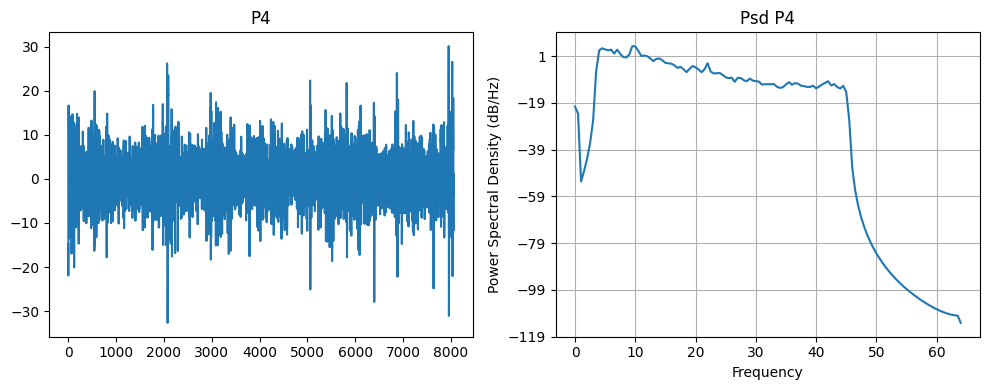

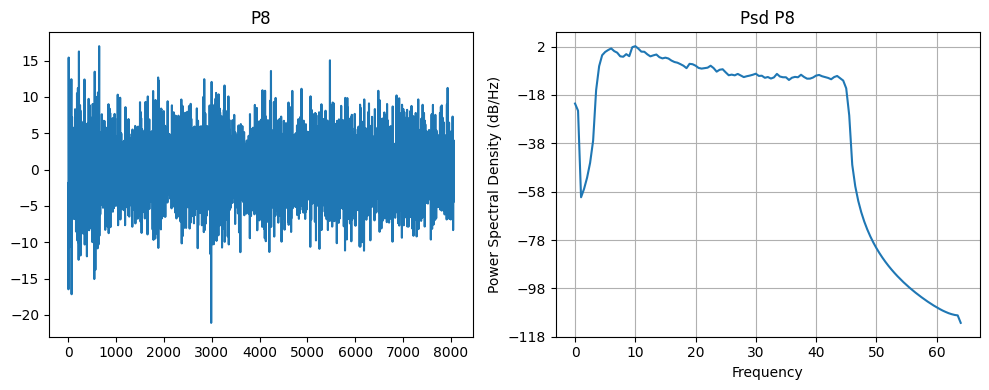

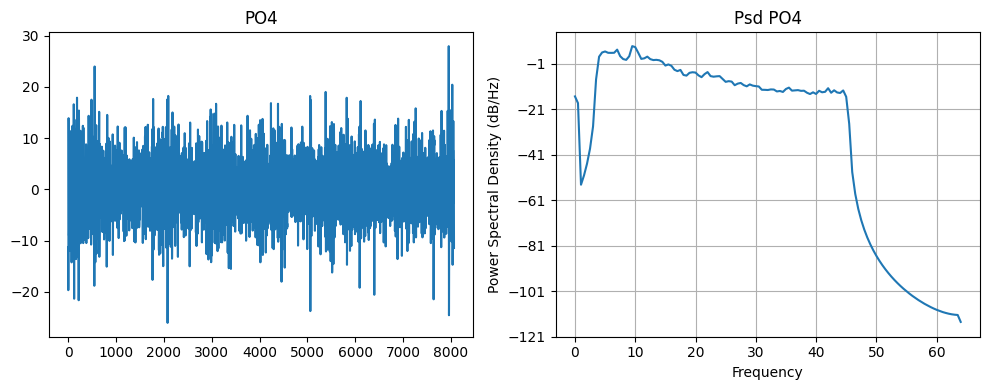

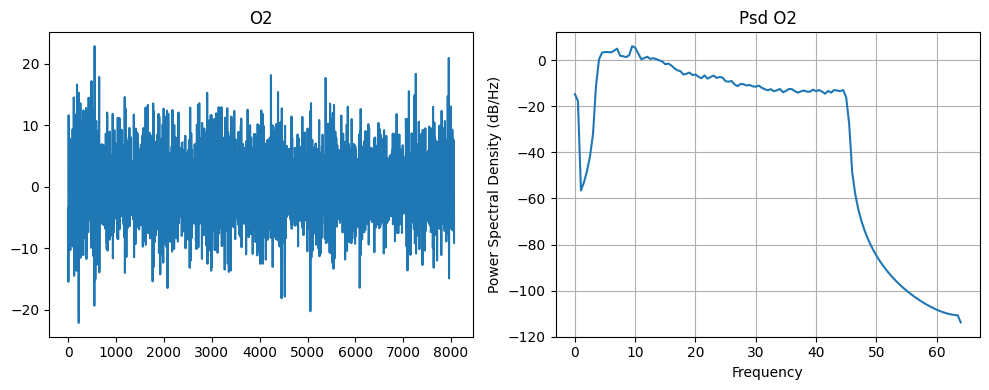

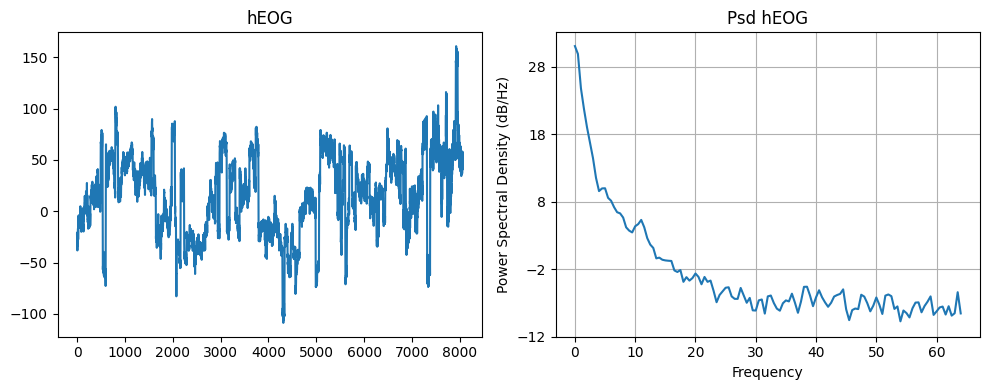

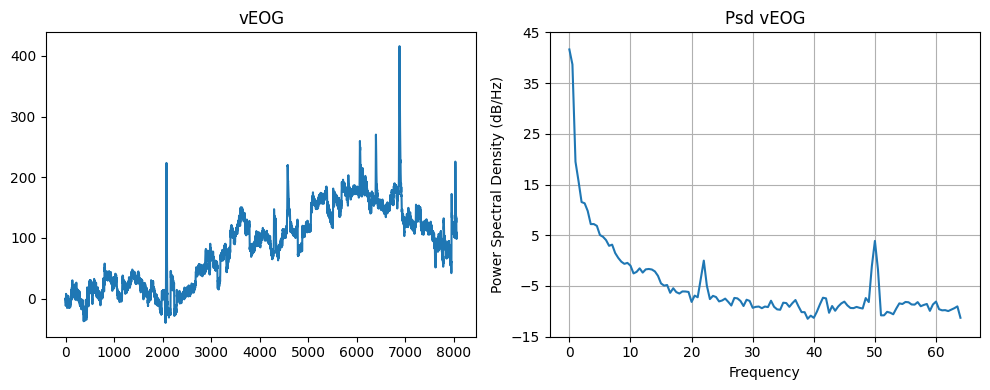

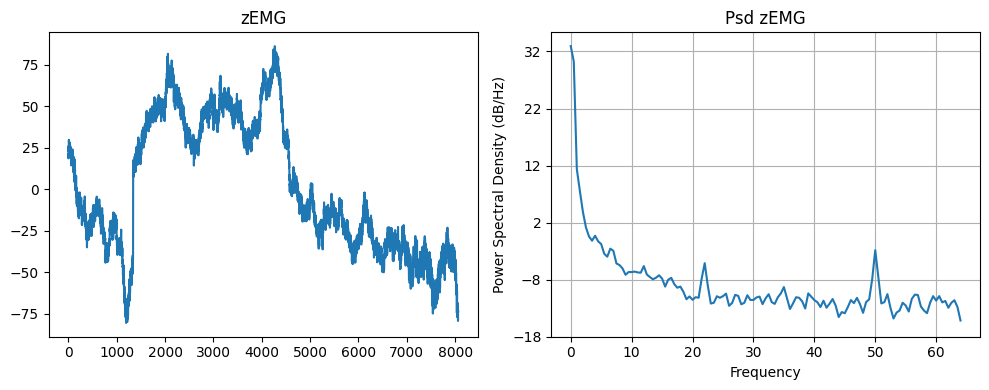

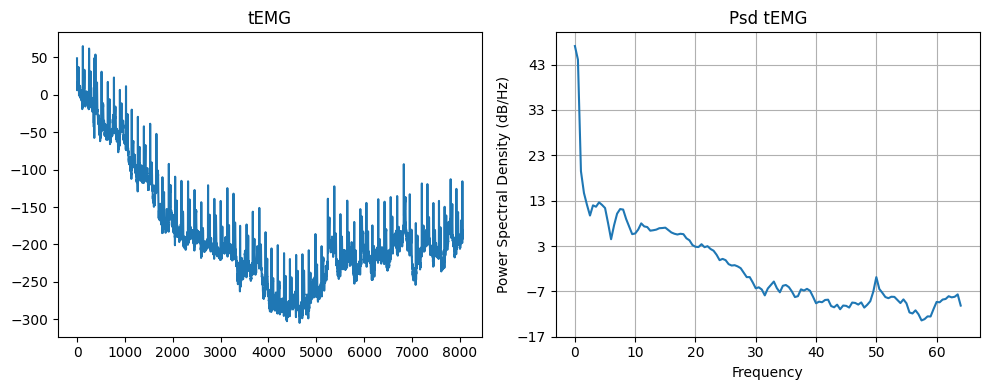

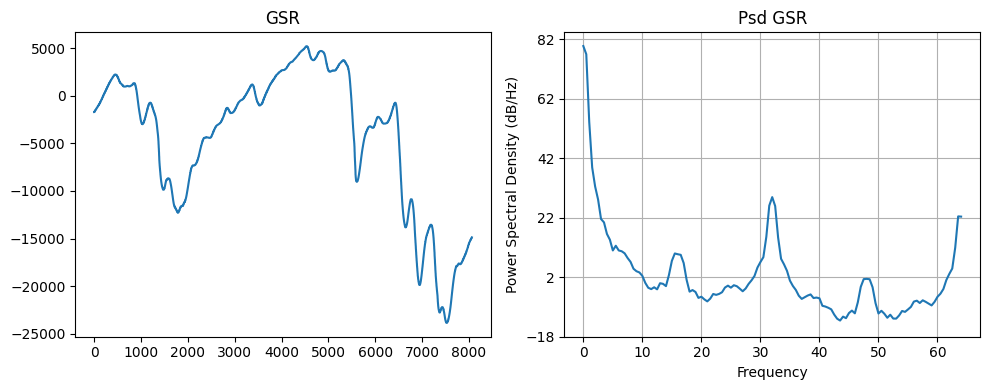

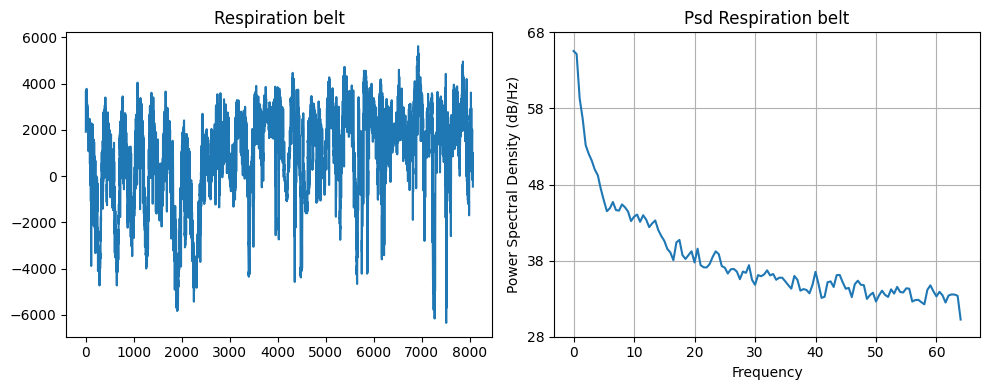

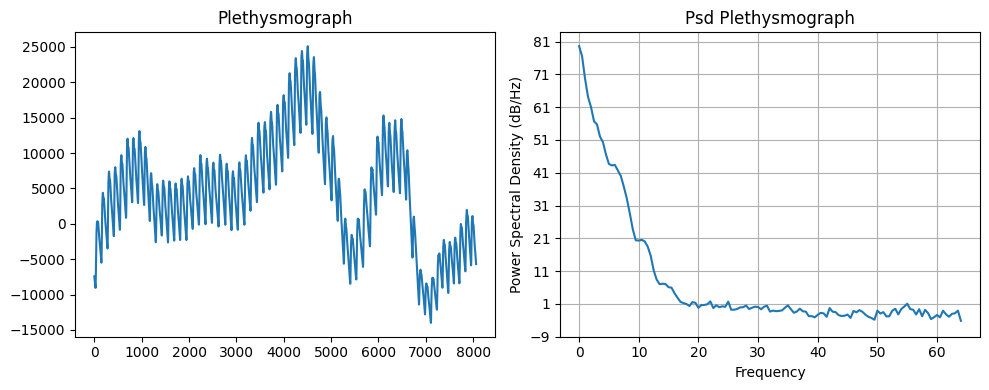

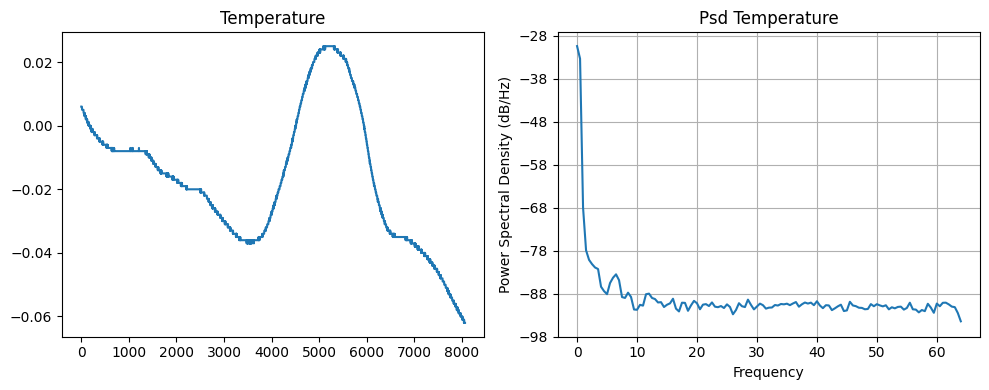

In [8]:
for i in range(40):
  # Crear una figura con dos subplots horizontales
  fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

  # Primer subplot
  axs[0].plot(matdatos[0][1][i]) #todos los canales del segundo trial del primer sujeto
  axs[0].set_title(canales[i])
  # Segundo subplot
  axs[1].psd(matdatos[0][1][i],Fs=fs)
  axs[1].set_title(f'Psd {canales[i]}')

  # Mostrar el gráfico
  plt.tight_layout()  # Para ajustar el espaciado entre subplots
  plt.show()


In [9]:
t=np.linspace(0, len(matdatos[0,0,0])/fs,len(matdatos[0,0,0]))

In [10]:
"""#NO EJECUTAR ESTO, pero es un buen template
for i in range(32):
  # Crear una figura con dos subplots horizontales
  fig, axs = plt.subplots(nrows=10, ncols=4, figsize=(15, 20))
  for j in range(40):

    # Primer subplot
    axs[j//4][j%4].psd(matdatos[i][1][j],Fs=fs) #todos los canales del segundo trial del primer sujeto
    axs[j//4][j%4].set_title(canales[j])

    # Mostrar el gráfico
    plt.tight_layout()  # Para ajustar el espaciado entre subplots
  plt.show()
"""

'#NO EJECUTAR ESTO, pero es un buen template\nfor i in range(32):\n  # Crear una figura con dos subplots horizontales\n  fig, axs = plt.subplots(nrows=10, ncols=4, figsize=(15, 20))\n  for j in range(40):\n\n    # Primer subplot\n    axs[j//4][j%4].psd(matdatos[i][1][j],Fs=fs) #todos los canales del segundo trial del primer sujeto\n    axs[j//4][j%4].set_title(canales[j])\n\n    # Mostrar el gráfico\n    plt.tight_layout()  # Para ajustar el espaciado entre subplots\n  plt.show()\n'

##Labels

sujetosxvideoxlabel

Visualizamos los resultados de la clasificación según el paper que realizó la adquisición de las señales. Ellos se basaron en la escala de Russell de valence-arousal para describir las emociones de manera cuantitativa, donde:

* **arousal** puede variar desde inactivo (por ejemplo,
desinteresado, aburrido) hasta activo (por ejemplo, alerta, emocionado).
* **valence** varía desde desagradable (por ejemplo, triste, estresado) hasta agradable (por ejemplo, feliz, eufórico).

In [11]:
# Seleccionamos las calificaciones de valence y arousal
valence = matlabels[:, :, 0]  # (32, 40)
arousal = matlabels[:, :, 1]  # (32, 40)

meanvalence = np.mean(valence, axis=1, keepdims=True)  # (32, 1)
meanarousal = np.mean(arousal, axis=1, keepdims=True)

valence_centered = valence - meanvalence  # (32, 40)
arousal_centered = arousal - meanarousal

In [12]:
"""# Crear una figura con dos subplots horizontales
fig, axs = plt.subplots(nrows=8, ncols=4, figsize=(15, 20))
for j in range(32):
  pasteles = [
    "turquoise", "lightcoral", "plum", "yellowgreen", "cornflowerblue",
    "#FFB7CE", "skyblue", "#E4C1F9", "#C1C8E4", "#C1E4F9",
    "#FFD1BA", "#FFE4BA", "gold", "#D1FFBA", "#BAFFE4",
    "#B3D1FF", "#D1BAFF", "#E4BAFF", "#F9BAFF", "#FFBAD1",
    "#FFDAC1", "#FFF5BA", "#BAFFD1", "#BAF9FF", "#BAC1FF",
    "#D1BAE4", "#E4D1BA", "#FFC1BA", "#F9E4BA", "#BAFFD1",
    "#EAD1DC", "#DCE1EA",'mediumorchid','orange', 'teal', 'mediumaquamarine', 'lightsalmon', 'palevioletred', 'darkturquoise', 'mediumvioletred'
]
  # Primer subplot
  axs[j//4][j%4].scatter(arousal_centered[j,:],valence_centered[j,:], c=pasteles) #todos los canales del segundo trial del primer sujeto
  axs[j//4][j%4].set_title(f'Sujeto {j+1}')
  axs[j//4][j%4].grid()
  axs[j//4][j%4].axhline(0, color='black', linewidth=0.5)
  axs[j//4][j%4].axvline(0, color='black', linewidth=0.5)
  axs[j//4][j%4].set_xlim(-6,6)
  axs[j//4][j%4].set_ylim(-6,6)
  axs[j//4][j%4].set_xlabel("Valence")
  axs[j//4][j%4].set_ylabel('Arousal')

  plt.tight_layout()
plt.show() # Para ajustar el espaciado entre subplots"""


'# Crear una figura con dos subplots horizontales\nfig, axs = plt.subplots(nrows=8, ncols=4, figsize=(15, 20))\nfor j in range(32):\n  pasteles = [\n    "turquoise", "lightcoral", "plum", "yellowgreen", "cornflowerblue",\n    "#FFB7CE", "skyblue", "#E4C1F9", "#C1C8E4", "#C1E4F9",\n    "#FFD1BA", "#FFE4BA", "gold", "#D1FFBA", "#BAFFE4",\n    "#B3D1FF", "#D1BAFF", "#E4BAFF", "#F9BAFF", "#FFBAD1",\n    "#FFDAC1", "#FFF5BA", "#BAFFD1", "#BAF9FF", "#BAC1FF",\n    "#D1BAE4", "#E4D1BA", "#FFC1BA", "#F9E4BA", "#BAFFD1",\n    "#EAD1DC", "#DCE1EA",\'mediumorchid\',\'orange\', \'teal\', \'mediumaquamarine\', \'lightsalmon\', \'palevioletred\', \'darkturquoise\', \'mediumvioletred\'\n]\n  # Primer subplot\n  axs[j//4][j%4].scatter(arousal_centered[j,:],valence_centered[j,:], c=pasteles) #todos los canales del segundo trial del primer sujeto\n  axs[j//4][j%4].set_title(f\'Sujeto {j+1}\')\n  axs[j//4][j%4].grid()\n  axs[j//4][j%4].axhline(0, color=\'black\', linewidth=0.5)\n  axs[j//4][j%4].axvline(

#Preprocesamiento

The trend of the ECG and GSR signals was removed by subtracting the temporal low frequency drift. The low frequency drift was computed by smoothing the signals on each ECG and GSR channels with a 256 points moving average.

tengo mis dudas, las primeras señales parecen estar preprocesadas xq no tienen deriva, mas abajo no se. la pletismografia me da dudas y no se como se deberian ver los emgs



These files contain a downsampled (to 128Hz), preprocessed and segmented version of the data in Matlab (data_preprocessed_matlab.zip) and pickled python/numpy (data_preprocessed_python.zip) formats. This version of the data is well-suited to those wishing to quickly test a classification or regression technique without the hassle of processing all the data first. Each zip file contains 32 .dat (python) or .mat (matlab) files, one per participant. Some sample code to load a python datafile is below:

GSR provides a measure of the resistance of the skin by positioning two electrodes on the distal phalanges of the middle and index fingers. This resistance decreases due to an increase of perspiration, which usually occurs when one is experiencing emotions such as stress or surprise

##Filtro pasa bandas

In [13]:
def Filtro(senal, wp, wr, fs=fs):
  # si wp y wr son intervalos, tenemos un pasa banda. Si wr> wp tenemos pasa bajos
  sos = sig.iirdesign(wp,wr,0.1,45,output='sos' ,fs=fs)
  frecuencia, respuesta = sig.sosfreqz(sos, fs=fs)
  filtrada = sig.sosfiltfilt(sos,senal)
  return filtrada

Para el filtrado de la señal de temperatura (baja frecuencia por los cambios lentos de temperatura en el cuerpo) se optó por el uso de un filtro pasa bajos con frecuencia de corte en 2Hz.

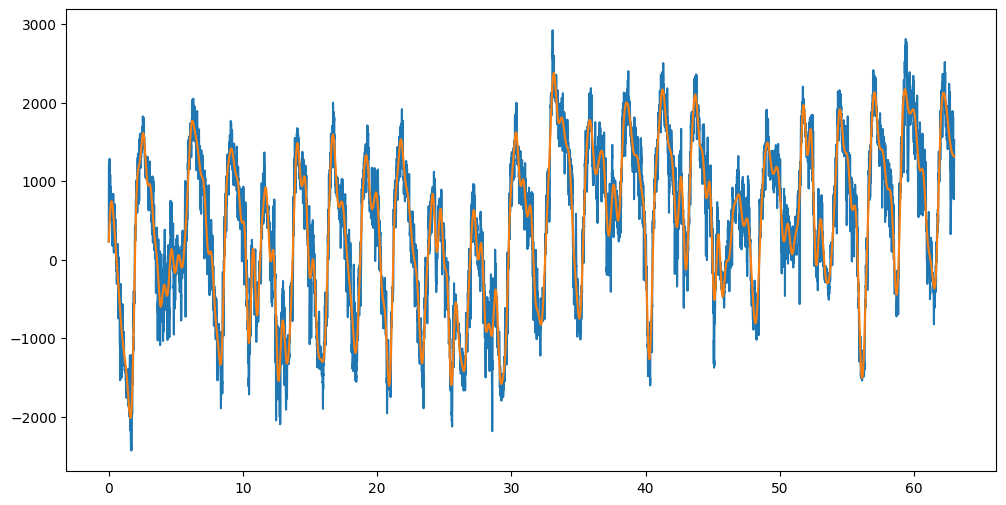

In [14]:
temp_filtrada=Filtro(matdatos[0, 0, 37],2,2.1, fs)
plt.figure(figsize=(12,6))
plt.plot(t, matdatos[0, 0, 37])
plt.plot(t, temp_filtrada)
plt.show()

A simple vista, en el dominio de tiempo, no se pueden visualizar grandes cambios más alla de la eliminación de lo que parece ser ruido de alta frecuencia. Para interpretar mejor los resultados, se realizó el PSD donde se puede ver que se conservan las frecuencias menores a los 2Hz donde se considera que se encuentra el componente de interés de la señal.

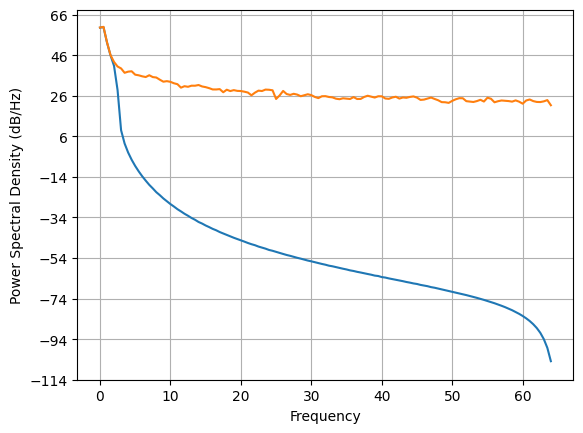

In [15]:
plt.psd(temp_filtrada,Fs=fs)
plt.psd(matdatos[0][0][37],Fs=fs)
plt.show()

#Extracción de características

donde pueden encontrar más correspondencia es en las frecuencias dominantes de cada señal (frecuencia del pico máximo del periodograma) y potencia en distintas bandas de interés (área bajo la curva del periodograma).

In [16]:
caracts=np.zeros((32*40,20)) #el 20 fue para tirar, va valence, arousal, n potencias, gsr tonico, fasico, temp, frec cardiaca y hrv

##EEG


 Se puede encontrar más correspondencia es en las frecuencias dominantes de cada señal (frecuencia del pico máximo del periodograma) y potencia en distintas bandas de interés (área bajo la curva del periodograma).


In [17]:
def welch(senal, nseg, fs=fs):
  nperseg=len(senal)/nseg
  f,s_psd= sig.welch(senal,fs=fs,nperseg=nperseg)
  return f,s_psd

Se calcula la potencia acumulada de cada ritmo respecto a la potencia total de ese canal. Al normalizar las contribuciones, obtenemos una idea de la proporción de la potencia total que contribuye cada ritmo específico. De este modo, se puede analizar los ritmos que predominan y cuales son los que se encuentran más desviados.

Para ello, con la función histog calculamos el área bajo la curva de psd correspondiente a cada ritmo y la dividimos por el ancho de banda de ese ritmo. Es decir que, para un canal específico, calculamos la potencia de cada ritmo y también los sumamos obteniendo la potencia total. Luego dividimos cada componente por ese valor obteniendo el vector de potencias normalizadas.

In [18]:
def histog(f, psd, bandas, fs=fs):
  """
  Realiza el el análisis de la distribución de potencia acumulada.

  Parámetros:
  -----------
  f :
      eje de frecuencias del PSD.
  x :
      PSD de un canal específico del EEG.
  fs:
      Frecuencia de muestreo en Hz.
  bandas:
      Diccionario con los rangos con las bandas de interés.
      ritmos_cerebrales ={ "delta": [1,4], "theta":[4,8], "alpha": [8,13], "sigma": [13,15], "beta": [15,30], "gamma": [30,100]}

  Devuelve:
  ---------
  Las bandas del histograma de potencias normalizado.
  """
  frecuencias = []
  pot_norm = []

  for banda, (min,max) in bandas.items(): #me recorre los ritmos
      s1 = []
      pot_banda=0
      for j in range(len(f)):
        if(f[j] >= min and f[j] < max):
          s1.append(psd[j])

      pot_banda= np.sum(s1)/(max-min) #densidad promedio de potencia en esa banda
      pot_norm.append(pot_banda)

  #potTotal=np.sum(psd)/(fs/2)
  #relacion = pot_norm/potTotal

  return pot_norm

In [19]:
def extract_eeg_features(eeg_data, fs):
    """
    Extrae características del EEG: potencia en bandas, coherencia y asimetría de potencia.

    Parámetros:
    -----------
    eeg_data : ndarray
        Señal EEG de múltiples canales con dimensiones (canales, muestras).
    fs : float
        Frecuencia de muestreo en Hz.

    Devuelve:
    ---------
    features : dict
        Diccionario con las características extraídas.
    """
    def wavelet_bands(signal, fs):
        """Calcula la potencia en bandas usando wavelet."""
        bands = {'delta': 4, 'theta': 3, 'alpha': 2, 'beta': 1, 'gamma': 0}  # Mapear bandas a niveles
        coeffs = pywt.wavedec(signal, 'db4', level=5)  # 5 niveles
        band_powers = {}

        for band, level in bands.items():
            band_coeffs = coeffs[level]  # Extrae los coeficientes del nivel correspondiente
            band_powers[band] = np.sum(np.square(band_coeffs))/len(band_coeffs)  # Calcula la energía (potencia)

        # Normalizar las bandas
        total_power = np.sum(list(band_powers.values()))
        for band in band_powers:
            band_powers[band] /= total_power

        return band_powers

    def calculate_coherence(eeg_data, fs):
        """Calcula la coherencia entre pares de canales."""
        coherences = []
        num_channels = eeg_data.shape[0]
        for i in range(num_channels):
            for j in range(i + 1, num_channels):
                f, Cxy = sig.coherence(eeg_data[i], eeg_data[j], fs=fs)
                mean_coherence = np.mean(Cxy)
                coherences.append(mean_coherence)
        return np.mean(coherences)  # Promedio entre pares

    def calculate_asymmetry(eeg_data):
        """Calcula la asimetría de potencia entre hemisferios."""
        # Indices de canales hemisféricos
        left_channels = [0, 2, 6]  # Fp1, F3, C3
        right_channels = [15, 19, 23]  # Fp2, F4, C4
        asymmetry = []
        for l, r in zip(left_channels, right_channels):
            power_left = np.sum(np.square(eeg_data[l]))
            power_right = np.sum(np.square(eeg_data[r]))
            asymmetry.append((power_left - power_right) / (power_left + power_right))
        return np.mean(asymmetry)

    # Inicialización de características
    features = {}
    num_channels = eeg_data.shape[0]
    print("cant canales:", num_channels)

    # Extracción de potencias en bandas para cada canal
    band_features = {f"{band}_power": [] for band in ['delta', 'theta', 'alpha', 'beta', 'gamma']}
    for channel in range(num_channels):
        band_powers = wavelet_bands(eeg_data[channel], fs)
        for band, power in band_powers.items():
            band_features[f"{band}_power"].append(power)
    for key in band_features:
        features[key] = np.mean(band_features[key])  # Promedio entre canales

    # Coherencia promedio
    features['mean_coherence'] = calculate_coherence(eeg_data, fs)

    # Asimetría de potencia
    features['power_asymmetry'] = calculate_asymmetry(eeg_data)

    return features
prueba= extract_eeg_features(matdatos[3,0,0:32], fs)

cant canales: 32


la coherencia se usa para medir la conectividad funcional entre diferentes regiones del cerebro. Esto puede implicar relaciones sincrónicas entre distintas áreas corticales durante ciertos estados emocionales o tareas cognitivas.

In [20]:
prueba

{'delta_power': 0.01027212694122746,
 'theta_power': 0.09259524283673892,
 'alpha_power': 0.6259006045333257,
 'beta_power': 0.2674079532860627,
 'gamma_power': 0.0038240724026451845,
 'mean_coherence': 0.5987607663680878,
 'power_asymmetry': 0.31755238055631946}

## GSR: media movil y pasaaltos

In [21]:
def mediamovil(señal, N=15):
  media=np.zeros(len(señal))
  for i in range(len(señal)):
    inf= max(0,i-N//2)
    sup= min(len(señal)-1,i+N//2)
    media[i]=np.mean(señal[inf:sup])

  return media

In [22]:
def componentes_GSR(señal, N, fs=fs):
  """
  Realiza el el análisis de los componentes del GSR (tónico y fásico).
  Primero se realiza la normailización de la señal para eliminar las diferencias indivisuales causadas por la linea de base.

  Parámetros:
  -----------
  f :
      GSR adquirido.
  N :
      cantidad de muestras de la ventana de la media móvil.
  fs:
      Frecuencia de muestreo en Hz.

  Devuelve:
  ---------
  Los dos componentes de la GSR.
  """
#Consideramos que los primeros 500 elementos corresponden a la linea de base.
  base= señal[:500]
  sig_normalizada = (señal- np.min(base))/(np.max(base)-np.min(base))
  tonico=mediamovil(sig_normalizada, N)
  fasico=Filtro(sig_normalizada, 0.05,0.01)
  return tonico, fasico, sig_normalizada

https://www.sciencedirect.com/science/article/pii/S0301051113002019?via%3Dihub#sec0055

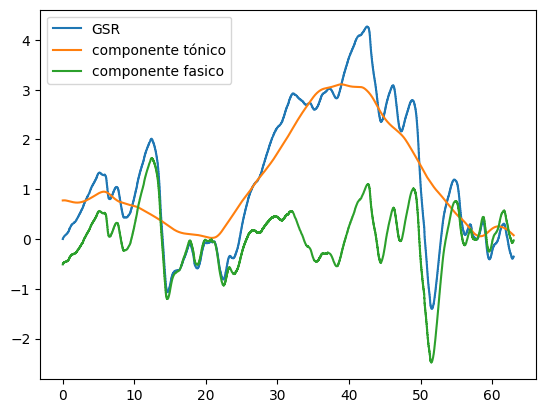

In [23]:
ton, fas, sig_n= componentes_GSR(matdatos[0,0,-4], 2000)
plt.plot(t, sig_n,label='GSR')
plt.plot(t,ton, label='componente tónico')
plt.plot(t,fas, label='componente fasico')
plt.legend()
plt.show()


In [24]:
media_GSR= np.mean(sig_n)
print("Media GSR:", media_GSR)

Media GSR: 1.19322067157807


Lang et al. discovered that the mean value of the GSR is related to the level of arousal

In [25]:
#interpolador
interp_func = interp1d(freqs, psd, kind='cubic')

# Nuevo vector de frecuencias con mayor resolución
high_res_freqs = np.linspace(0, 64, 1000)
high_res_psd = interp_func(high_res_freqs)

NameError: name 'interp1d' is not defined

In [ ]:
# Definir bandas de frecuencia para GSR
bandas = {
    'EDASymp': (0.045, 0.25),
}

frequencies, psd = welch(matdatos[15,0,-4], nseg=15, fs=128)

# Calcular la potencia en cada banda
powers= histog(frequencies, psd, bandas)

# Potencia total y normalización
total_power = np.sum(psd)
powers_normalized = powers / total_power

# Resultados
print("Potencias por banda:", powers)
print("Potencias normalizadas:", powers_normalized)

In [ ]:

plt.figure(figsize=(10, 6))
plt.semilogy(frequencies, psd, label='PSD (GSR)')
for band, (low, high) in bandas.items():
    plt.axvspan(low, high, color='gray', alpha=0.3, label=f'Banda {band}')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Densidad espectral de potencia [uS²/Hz]')
plt.title('Análisis espectral de GSR')
plt.legend(loc='upper right')
plt.grid()
plt.show()


## Temperatura

In [ ]:
temp_filtrada

## Pletismografía, Locura total del chat

In [ ]:
def hrv_from_ppg(ppg, fs):
    """
    Calcula HRV (Heart Rate Variability) a partir de una señal PPG.

    Parámetros:
        ppg_signal: array
            Señal PPG cruda.
        fs: int
            Frecuencia de muestreo (Hz).

    Retorna:
        dict
            Características del HRV en el dominio temporal y frecuencial.
    """

    # 2. Detectar picos
    peaks, _ = sig.find_peaks(ppg, distance=fs*0.5)  # Considerando al menos 0.5s entre picos (~120 BPM máx.)

    # 3. Calcular intervalos RR (en segundos)
    rr_intervals = np.diff(peaks) / fs  # Convertir diferencias de muestras a segundos

    # 4. Calcular características del HRV
    if len(rr_intervals) > 1:
        mean_rr = np.mean(rr_intervals)
        sdnn = np.std(rr_intervals)
        rmssd = np.sqrt(np.mean(np.square(np.diff(rr_intervals))))
    else:
        mean_rr, sdnn, rmssd = None, None, None

    # Dominio temporal
    hrv_features = {
        'mean_rr': mean_rr,
        'sdnn': sdnn,
        'rmssd': rmssd,
        # Puedes incluir más métricas según lo necesites
    }

    # Opcional: Análisis frecuencial del HRV (puedes agregar si es necesario)
    # 5. Transformada de Fourier para calcular la potencia en LF y HF
    if len(rr_intervals) > 4:  # Requiere suficientes datos para el análisis
        freq = np.fft.rfftfreq(len(rr_intervals), d=np.mean(rr_intervals))
        power_spectrum = np.abs(np.fft.rfft(rr_intervals))**2
        lf_power = np.sum(power_spectrum[(freq >= 0.04) & (freq < 0.15)])
        hf_power = np.sum(power_spectrum[(freq >= 0.15) & (freq < 0.4)])
        hrv_features['lf_power'] = lf_power
        hrv_features['hf_power'] = hf_power

    return hrv_features

# Ejemplo de uso:
fs = 128  # Frecuencia de muestreo en Hz
hrv_features = hrv_from_ppg(matdatos[0,0,-2], fs)
print(hrv_features)


Fuentes de referencia:

Pan J, Tompkins WJ. A real-time QRS detection algorithm. IEEE Trans Biomed Eng. 1985. Este algoritmo es ampliamente adaptado para señales PPG.

Shaffer F, Ginsberg JP. An overview of heart rate variability metrics and norms. Front Public Health. 2017.

Berntson GG, et al. Heart rate variability: Origins, methods, and interpretive caveats. Psychophysiology. 1997.

##Frecuencia Respiratoria


#Machine Learning
